In [1]:
import torch
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transform
from sklearn.preprocessing import MinMaxScaler

In [2]:
class SismicDataset(Dataset):
    def __init__(self, max_length=572427):
        # Cargar el catálogo CSV
        self.cat = pd.read_csv('./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')
        self.data_directory = './data/lunar/training/data/S12_GradeA'
        self.max_length = max_length  # Define la longitud máxima de las secuencias

    def __len__(self):
        return len(self.cat)

    def __getitem__(self, idx):
        # Obtener los datos de la fila correspondiente
        row = self.cat.iloc[idx]
        test_filename = row['filename']
        arrival_time_rel = row['time_rel(sec)']
        

        # Construir la ruta al archivo .mseed
        mseed_file = os.path.join(self.data_directory, f'{test_filename}.mseed')

        # Leer los datos de la señal usando obspy
        st = read(mseed_file)
        
        #Filtro de band pass para frecuencias
        st_filt = st.copy()
        st_filt.filter('bandpass',freqmin=0.5,freqmax=1.0)
        tr_filt = st_filt.traces[0].copy()
        tr_times_filt = tr_filt.times()
        tr_data_filt = tr_filt.data

        #Filtro de normalizacion de velocidades
        tr_data_filt_norm = tr_data_filt.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        tr_data = scaler.fit_transform(tr_data_filt_norm)
        tr_data = tr_data.reshape(-1)

        #Filtro de normalizacion de tiempos
        tr_times_norm = tr_times_filt.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        tr_times_norm_filter = scaler.fit_transform(tr_times_norm)

        #Tiempo de evento normalizado
        arrival_norm = arrival_time_rel/tr_times_filt.max()

        # Verificar si la señal es más larga que la longitud máxima y truncarla si es necesario
        if len(tr_data) > self.max_length:
            tr_data = tr_data[:self.max_length]
        # Si la señal es más corta, añadir ceros al final (padding)
        elif len(tr_data) < self.max_length:
            tr_data = np.pad(tr_data, (0, self.max_length - len(tr_data)), 'constant')

        # Convertir los datos a tensores
        signal = torch.tensor(tr_data, dtype=torch.float32)
        label = torch.tensor(arrival_norm, dtype=torch.float32)

        return signal, label

In [118]:
def size_out(w,f,p=0,s=1):
    return(w-f+2*p)/s+1

class SeismicCNN(nn.Module):
    def __init__(self):
        super(SeismicCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=500, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=200)

        self.conv2 = nn.Conv1d(8, 16, kernel_size=25, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=5)

        self.conv3 = nn.Conv1d(16, 32, kernel_size=25, padding=0)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=5)

        self.dropout = nn.Dropout(0.5)

        # Ahora podemos definir fc1 con una dimensión de entrada fija
        self.fc1 = None  # Se inicializa dinámicamente más adelante

        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 32)
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 32)
        self.relu_fc3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        # x tiene forma (batch_size, signal_length)
        x = x.unsqueeze(1)  # Añadir dimensión de canal: (batch_size, 1, signal_length)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.dropout(x)


        
        if self.fc1==None:
            self.fc1 = nn.Linear(x.shape[2]*32,32)
            self.fc1 .to(x.device)

        x=x.view(x.shape[0],-1)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.fc3(x)
        x = self.relu_fc3(x)
        x = self.fc4(x)
        return x.squeeze()  # Devolver tensor de forma (batch_size)

In [ ]:
model = SeismicCNN()

model()

In [57]:
testdata = SismicDataset()

signal = testdata[75][0]

print(signal)
signal = signal.unsqueeze(0)
signal = signal.unsqueeze(0)
print(signal.shape)

def size_out(w,f,p=0,s=1):
    return(w-f+2*p)/s+1

conv1 = nn.Conv1d(1, 8, 16, padding=0)
pool = nn.MaxPool1d(kernel_size=8)
conv2 = nn.Conv1d(8, 16, 32, padding=0)

tamañofinal=0

x = conv1(signal)
print('conv1 ', x.shape)
tamañofinal = size_out(signal.shape[2], 16)
x = pool(x)
print('pool1 ',x.shape)
tamañofinal = int(tamañofinal/8)
x=conv2(x)
print('conv2 ',x.shape)
tamañofinal = size_out(tamañofinal, 32)
x= pool(x)
print('pool2 ',x.shape)
tamañofinal = int(tamañofinal/8)



print('size: ', tamañofinal)
print('size2: ', x.shape[2])


tensor([0.0265, 0.0265, 0.0265,  ..., 0.0000, 0.0000, 0.0000])
torch.Size([1, 1, 572427])
conv1  torch.Size([1, 8, 572412])
pool1  torch.Size([1, 8, 71551])
conv2  torch.Size([1, 16, 71520])
pool2  torch.Size([1, 16, 8940])
size:  8940
size2:  8940


In [119]:
#Extraer datos
dataset = SismicDataset()
#Cargar datos
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=0)

# Dividir en conjuntos de entrenamiento y validación
train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
print("tamaño del dataset_train: ",len(train_dataset))######################################################
print("tamaño del val_dataset: ",len(val_dataset))######################################################

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

#modelo
model = SeismicCNN()

#training loop
total_samples = len(train_loader)
n_iter =  int(total_samples/4)
print(total_samples, n_iter)

######################
#parameters
learning_rate=0.001
n_epochs = 20*5

# Definir funcion de pérdida y optimizador
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Mover el modelo al dispositivo adecuado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Listas para almacenar las pérdidas
train_losses = []
#val_losses = []
for epoch in range(n_epochs):
    running_loss = 0
    for i, (inputs, labels) in  enumerate(train_loader):
        #origin shape : [4, 572427]
        #forward, backward, update
        inputs = inputs.to(device)
        labels = labels.to(device)
        #forward
        outputs = model(inputs)
        #print('Outputs: ', outputs)
        train_loss = loss(labels, outputs)
        

        #backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()       

        if (i+1)%10==0:
            print(f'epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iter}, inputs {inputs.shape[0]}, Training Loss: {train_loss.item():.4f}')
    train_losses.append(train_loss.item())



tamaño del dataset_train:  60
tamaño del val_dataset:  16
15 3
epoch 1/100, step 10/3, inputs 4, Training Loss: 0.2813
epoch 2/100, step 10/3, inputs 4, Training Loss: 0.3851
epoch 3/100, step 10/3, inputs 4, Training Loss: 0.2791
epoch 4/100, step 10/3, inputs 4, Training Loss: 0.3949
epoch 5/100, step 10/3, inputs 4, Training Loss: 0.1752
epoch 6/100, step 10/3, inputs 4, Training Loss: 0.2249
epoch 7/100, step 10/3, inputs 4, Training Loss: 0.2049
epoch 8/100, step 10/3, inputs 4, Training Loss: 0.2279
epoch 9/100, step 10/3, inputs 4, Training Loss: 0.5290
epoch 10/100, step 10/3, inputs 4, Training Loss: 0.4425
epoch 11/100, step 10/3, inputs 4, Training Loss: 0.1339
epoch 12/100, step 10/3, inputs 4, Training Loss: 0.3115
epoch 13/100, step 10/3, inputs 4, Training Loss: 0.2564
epoch 14/100, step 10/3, inputs 4, Training Loss: 0.2347
epoch 15/100, step 10/3, inputs 4, Training Loss: 0.1016
epoch 16/100, step 10/3, inputs 4, Training Loss: 0.0387
epoch 17/100, step 10/3, inputs 4,

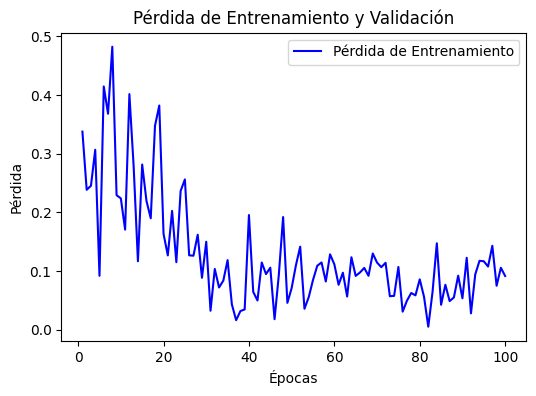

In [115]:
# Graficar las pérdidas
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, 'b', label='Pérdida de Entrenamiento')
#plt.plot(epochs, val_losses, 'r', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
dataloader
for i, (inputs, labels) in  enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    #forward
    outputs = model(inputs)
    print(loss(labels, outputs).item())
    print("Targets: ", labels)
    print("predictions: ", outputs)


In [11]:
prueba = SismicDataset()

print(prueba[0][1])

input=prueba[0][1]
inputs.to(device)
predic = model(input)

print(predic)

tensor(0.8507)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)